In [1]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import json
import requests
import pandas as pd

# Middle Band = 20 day moving average
# Upper Band = 20 day moving average + (20 Day standard deviation of price x 2)
# Lower Band = 20 day moving average - (20 Day standard deviation of price x 2)

start_money = 100000
risk_free = 0.025
ticker = 'AAPL'
url = f"https://api.iextrading.com/1.0/stock/{ticker}/chart/1y"
data1 = json.loads(requests.get(url).content.decode())
df = pd.read_json(url)[['date', 'close']].copy()
df = df.dropna()
df.head()

,date,close
0,2017-09-28,150.9969
1,2017-09-29,151.8244
2,2017-10-02,151.5190
3,2017-10-03,152.1790
4,2017-10-04,151.1939


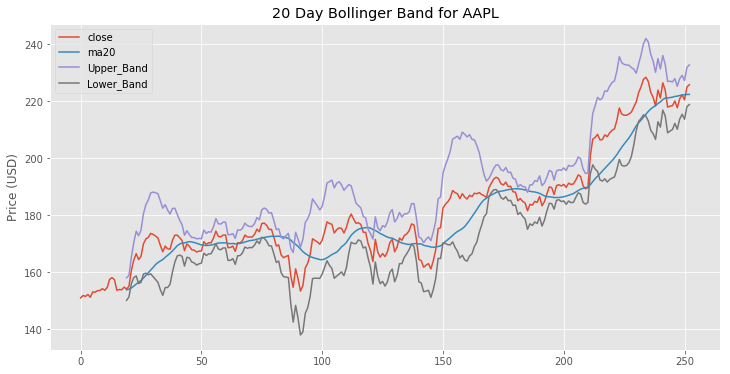

In [2]:
# Calculate 20 Day Moving Average, Std Deviation, Upper Band and Lower Band
df['ma20'] = df['close'].rolling(20).mean()
df['std20'] = df['close'].rolling(20).std()
df['Upper_Band'] = df['close'] + (df['std20'] * 2)
df['Lower_Band'] = df['close'] - (df['std20'] * 2)

# Simple 20 Day Bollinger Band for AAPL (2017-2018)
df[['close', 'ma20', 'Upper_Band', 'Lower_Band']].plot(figsize=(12,6))
plt.title('20 Day Bollinger Band for AAPL')
plt.ylabel('Price (USD)')
plt.show()

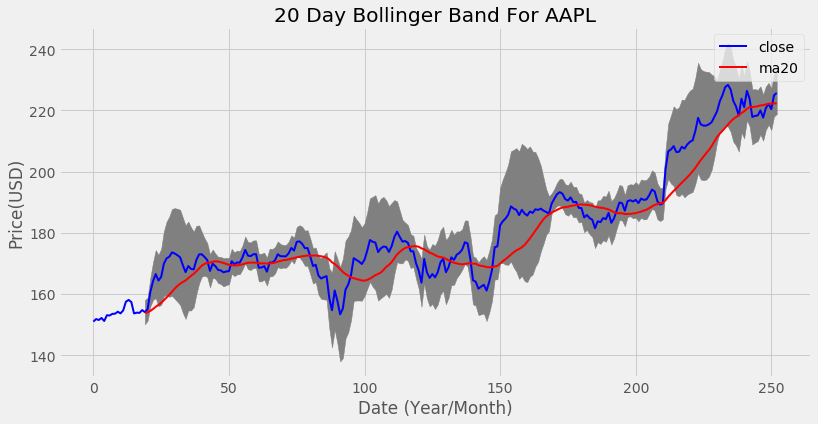

In [3]:
# Set style, empty figure and axes
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

# Get index values for the X axis for AAPL DataFrame
x_axis = df.index.get_level_values(0)


# Plot shaded 20 Day Bollinger Band for AAPL
ax.fill_between(x_axis, df['Upper_Band'], df['Lower_Band'], color='grey')

# Plot Closing Price and Moving Averages
ax.plot(x_axis, df['close'], color='blue', lw=2)
ax.plot(x_axis, df['ma20'], color='red', lw=2)

# Set Title & Show the Image
ax.set_title('20 Day Bollinger Band For AAPL')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()

plt.show()

In [4]:
cash = [start_money]
stock = [0]
net = [start_money]

In [5]:
df["yesterday"] = df["close"].shift(1)

In [6]:
#%b值 = (收盘价−布林带下轨值) ÷ (布林带上轨值−布林带下轨值)
#%b = (row.close-row.Lower_Band)/(row.Upper_Band - row.Lower_Band)
# create trading signals
signal = []
for idx,row in df.iterrows():
    if row.yesterday < row.close and row.close > row.ma20:
        signal.append(1)
    elif row.yesterday > row.close and row.close < row.ma20:
        signal.append(-1)
    elif (row.close-row.Lower_Band)/(row.Upper_Band - row.Lower_Band) > 0.8:
        singal.append(1)
    elif (row.close-row.Lower_Band)/(row.Upper_Band - row.Lower_Band) <= 0:
        singal.append(1)
    elif (row.close-row.Lower_Band)/(row.Upper_Band - row.Lower_Band) <= 0.2:
        singal.append(-1)
    else:
        signal.append(0)
df["signal"] = signal

In [8]:
for idx,row in df.iterrows():
    if row.signal == 1:
        shares_to_buy = int(cash[-1] / row.close)
        cost = shares_to_buy * row.close
        cash.append(cash[-1] - cost)
        stock.append(stock[-1] + shares_to_buy)
    elif row.signal == -1:
        cash.append(cash[-1] + stock[-1] * row.close)
        stock.append(0)
    else:
        cash.append(cash[-1])
        stock.append(stock[-1])
    net.append(stock[-1] * row.close + cash[-1])

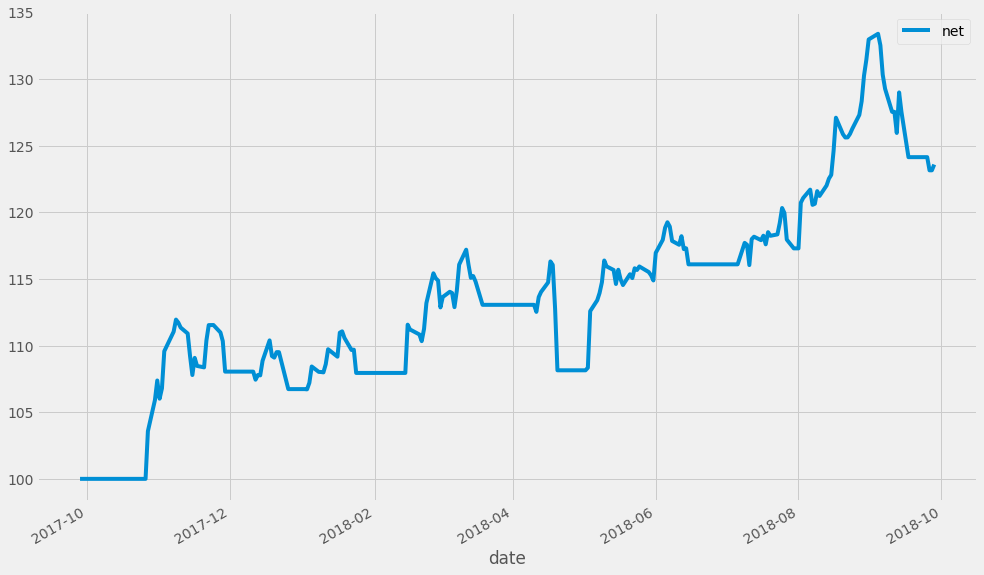

In [9]:
df['net'] = net[1:]
df['cash'] = cash[1:]
df['stock'] = stock[1:]
df['net'] = df['net'] / start_money * 100
df[['date', 'net']].set_index('date').plot(figsize=(15,10))